In [183]:
from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from youtube_transcript_api import YouTubeTranscriptApi
import streamlit as st
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from IPython.display import Image, display

# Load environment variables
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

# Initialize LLM
llm = ChatGroq(model="qwen-2.5-32b")

# Graph State
class State(TypedDict):
    user_input_requirements: str
    user_stories: str
    design_docs_functional: str
    design_docs_technical: str
    generate_code: str
    fixed_code: str
    test_cases: str
    po_feedback: str
    des_review_feedback:str
    code_review_feedback: str
    security_review_feedback: str
    testcase_review_feedback: str
    qa_testing_review_feedback: str

In [184]:
def user_input_reqs(state:State):
    print("User requirement", state["user_input_requirements"])

In [185]:
def create_user_stories(state: State):
    """Convert the user requirements into user stories"""
    #print("Inside create user stories")
    msg = llm.invoke(f"""You are a business analyst expert in writing user stories. Please take the user requirements {state['user_input_requirements']}
                     and convert it into user stories""")
    #print("User Stories: ", msg.content)
    print("User Stories Created")
    return ({"user_stories": msg.content})
        

In [186]:
def create_design_docs(state: State):
    """Create the functional and technical design documents"""
    if state['po_feedback'] == "Approved":
        msg1 = llm.invoke(f"""You are a funcational analyst and need to design functional document based on the user stories
                         {state["user_stories"]} and user requirements {state["user_input_requirements"]}.""")
        msg2 = llm.invoke(f"""You are a technical lead and need to design technical documents based on the user stories
                         {state["user_stories"]} and user requirements {state["user_input_requirements"]}. 
                         For techincal documents, you can use the UML diagrams as well.""")
        print("Functional and Technical Design Documents Created")
        return({"design_docs_functional":msg1.content, "design_docs_technical": msg2.content})
        

In [187]:
def gen_code(state:State):
    """Generate the code in java language based on the understanding from technical document"""
    if state['design_docs_technical'] != None:
        msg = llm.invoke(f"""You are an expert java programmer and based on your understandig from {state["design_docs_technical"]}, 
                         please write a java program on it.""")
        print("Code Generated")
        return ({"generate_code": msg.content})

In [188]:
def write_test_cases(state:State):
    if state["generate_code"] != None:
         msg = llm.invoke(f"""You are an QA. Based on the functional design document {state["design_docs_functional"]}, 
                         please write test cases..""")
         print("Test Cases Generated")
         return ({"test_cases": msg.content})

In [189]:
def product_owner_review(state:State):
     """Check if the user stories genearted are apt or not"""
     if state["user_stories"] != None:
          return({"po_feedback": "Approved"})
     else:
          return({"po_feedback": "Feedback"})

In [190]:
def po_feedback_approval(state:State):
    if state["po_feedback"] == "Approved":
        print("Product Owner Approved")
        return "Approved"
    else:
        return "Feedback"

In [191]:
def review_user_stories(state:State):
    """Check if the user stories are appropriate"""
    pass

In [192]:
def design_review(state:State):
    """Check if technical and functional documents are apt."""
    if state["design_docs_functional"] != None and state["design_docs_technical"] != None:
        return({"des_review_feedback":"Approved"})
    else:
        return({"des_review_feedback": "Feedback"})

def design_review_approval(state:State):
    """Approval from reviewer"""
    if state["des_review_feedback"] == "Approved":
        return "Approved"
    else:
        return "Feedback"
    

In [193]:
def code_review(state:State):
    """Check if code is correct or not"""
    if state["generate_code"] != None:
        return({"code_review_feedback":"Approved"})
    else:
        return({"code_review_feedback": "Feedback"})

def code_review_approval(state:State):
    """Approval from reviewer"""
    if state["code_review_feedback"] == "Approved":
        return "Approved"
    else:
        return "Feedback"

In [194]:
def fix_code_after_security(state:State):
    pass

In [195]:
def fix_code_after_code_review(state: State):
    pass

In [196]:
def security_review(state:State):
     if state["generate_code"] != None:
        return({"security_review_feedback" : "Approved"})
     else:
         return({"security_review_feedback" : "Feedback"})

def security_review_approval(state:State):
    """Approval from reviewer"""
    if state["security_review_feedback"] == "Approved":
        return "Approved"
    else:
        return "Feedback"

In [197]:
def test_cases_review(state:State):
     if state["test_cases"] != None:
        return({"testcase_review_feedback" : "Approved"})
     else:
         return({"testcase_review_feedback" : "Feedback"})

def test_cases_review_approval(state:State):
    """Approval from reviewer"""
    if state["testcase_review_feedback"] == "Approved":
        return "Approved"
    else:
        return "Feedback"

In [198]:
def fix_test_cases_after_review(state:State):
    pass

In [199]:
def QA_Testing(state:State):
     if state["test_cases"] != None:
        return({"qa_testing_review_feedback" : "Approved"})
     else:
         return({"qa_testing_review_feedback" : "Feedback"})

def qa_testing_approval(state:State):
    """Approval from reviewer"""
    if state["qa_testing_review_feedback"] == "Approved":
        return "Passed"
    else:
        return "Failed"

In [200]:
def fix_code_after_qa_feedback(state:State):
    pass

In [201]:
def Deployment(state:State):
    print("Deployment Completed")

def Monitoring_and_Feedback(state:State):
    print("Monitoring and Feedback Completed")

def Maintenance_and_Updates(state:State):
    print("Maintenance and Updates Completed")

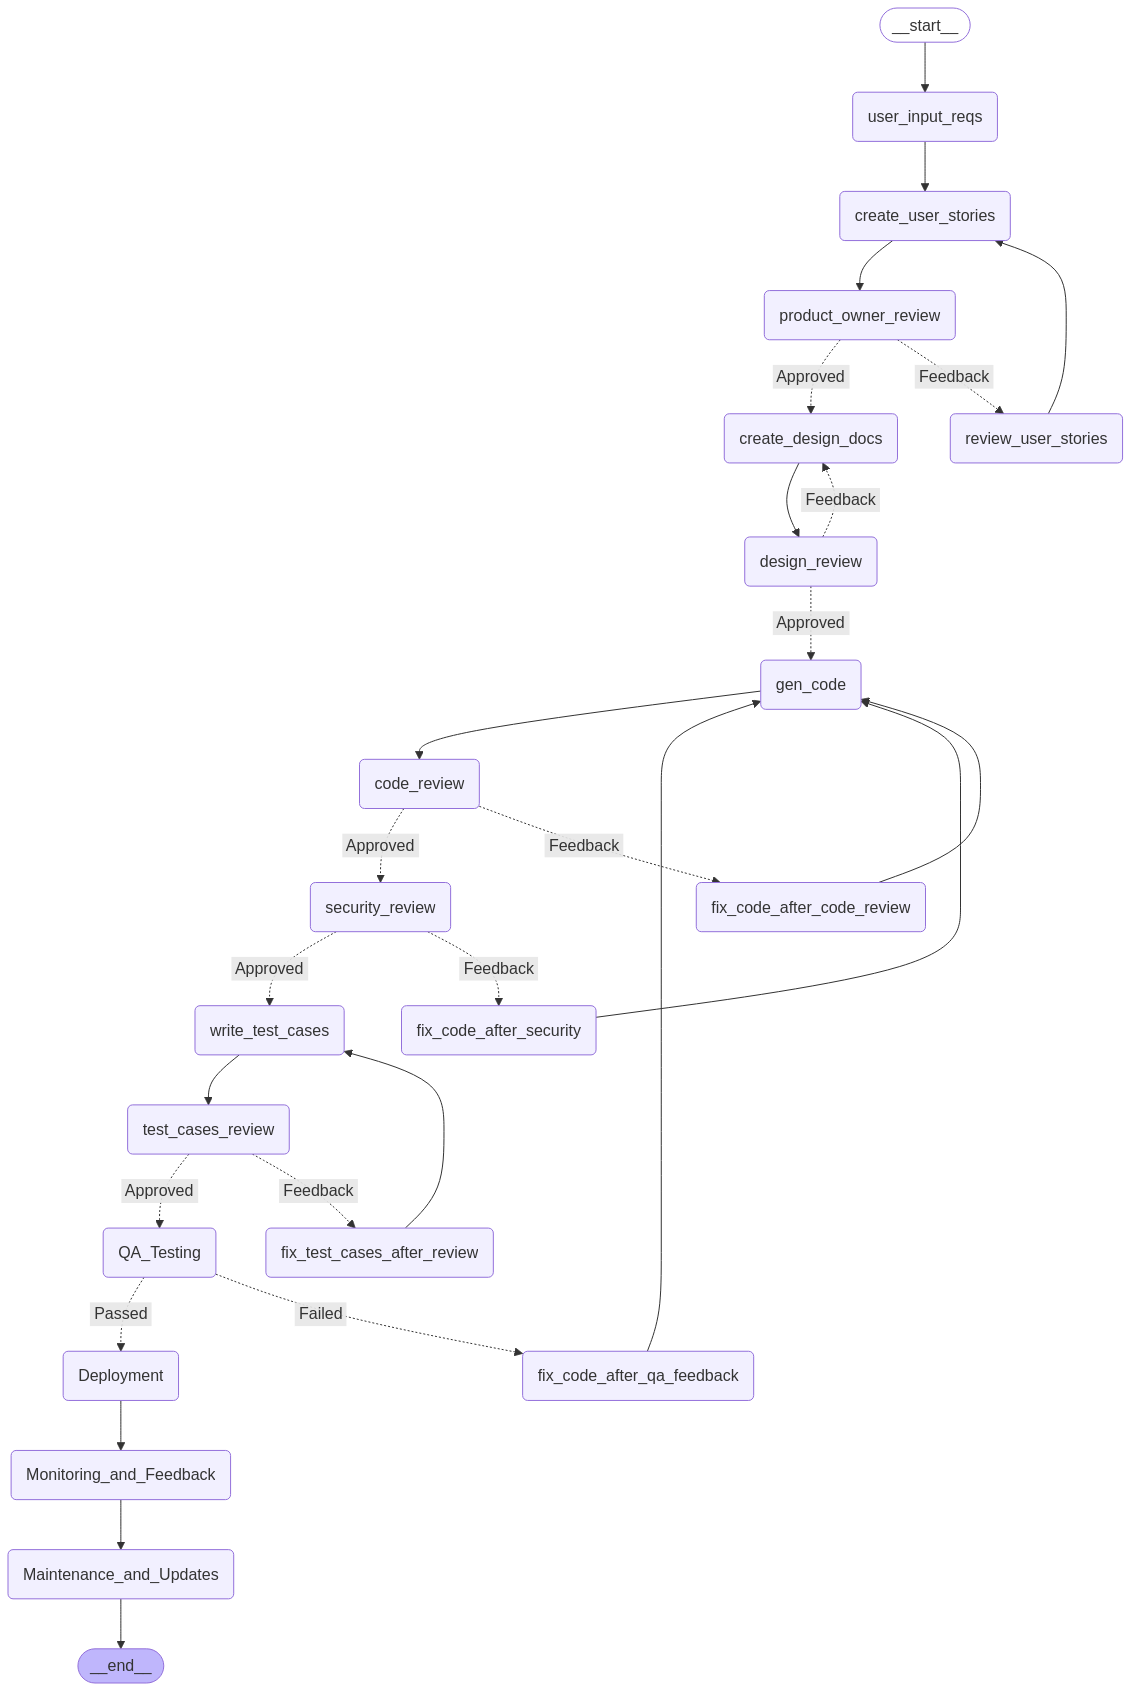

In [202]:
# Build and compile the workflow
workflow1 = StateGraph(State)
    
# Add nodes
workflow1.add_node("user_input_reqs", user_input_reqs)
workflow1.add_node("create_user_stories", create_user_stories)
workflow1.add_node("product_owner_review", product_owner_review)
workflow1.add_node("review_user_stories", review_user_stories)
workflow1.add_node("create_design_docs", create_design_docs)
workflow1.add_node("design_review", design_review)
workflow1.add_node("gen_code", gen_code)
workflow1.add_node("code_review", code_review)
workflow1.add_node("fix_code_after_code_review", fix_code_after_code_review)
workflow1.add_node("security_review", security_review)
workflow1.add_node("write_test_cases", write_test_cases)
workflow1.add_node("fix_code_after_security", fix_code_after_security)
workflow1.add_node("test_cases_review", test_cases_review)
workflow1.add_node("fix_test_cases_after_review", fix_test_cases_after_review)
workflow1.add_node("QA_Testing", QA_Testing)
workflow1.add_node("fix_code_after_qa_feedback", fix_code_after_qa_feedback)
workflow1.add_node("Deployment", Deployment)
workflow1.add_node("Monitoring_and_Feedback", Monitoring_and_Feedback)
workflow1.add_node("Maintenance_and_Updates", Maintenance_and_Updates)

    
# Add edges
workflow1.add_edge(START, "user_input_reqs")
workflow1.add_edge("user_input_reqs", "create_user_stories")
workflow1.add_edge("create_user_stories", "product_owner_review")
workflow1.add_conditional_edges(
    "product_owner_review",
    po_feedback_approval,
    {
        "Approved": "create_design_docs",
        "Feedback": "review_user_stories"
    }
    )
workflow1.add_edge("review_user_stories", "create_user_stories")
workflow1.add_edge("create_design_docs", "design_review")
workflow1.add_conditional_edges(
    "design_review",
    design_review_approval,
    {
        "Approved": "gen_code",
        "Feedback": "create_design_docs"
    }
    )
workflow1.add_edge("gen_code", "code_review")
workflow1.add_conditional_edges(
    "code_review",
    code_review_approval,
    {
        "Approved": "security_review",
        "Feedback": "fix_code_after_code_review"
    }
    )
workflow1.add_edge("fix_code_after_code_review", "gen_code")
workflow1.add_conditional_edges(
    "security_review", 
    security_review_approval,
    {
        "Approved": "write_test_cases",
        "Feedback": "fix_code_after_security"
    }
    )
workflow1.add_edge("fix_code_after_security", "gen_code")
workflow1.add_edge("write_test_cases", "test_cases_review")
workflow1.add_conditional_edges(
    "test_cases_review", 
    test_cases_review_approval,
    {
        "Approved": "QA_Testing",
        "Feedback": "fix_test_cases_after_review"
    }
    )
workflow1.add_conditional_edges(
    "QA_Testing", 
    qa_testing_approval,
    {
        "Passed": "Deployment",
        "Failed": "fix_code_after_qa_feedback"
    }
    )
workflow1.add_edge("fix_test_cases_after_review", "write_test_cases")
workflow1.add_edge("fix_code_after_qa_feedback", "gen_code")
workflow1.add_edge("Deployment", "Monitoring_and_Feedback")
workflow1.add_edge("Monitoring_and_Feedback", "Maintenance_and_Updates")
workflow1.add_edge("Maintenance_and_Updates", END)
# Compile
code_gen_agent = workflow1.compile()

# Show
display(Image(code_gen_agent.get_graph().draw_mermaid_png()))

In [203]:
input = "generate user stories to design a game of snakes and ladder"
code_gen_agent.invoke({"user_input_requirements":input})

User requirement generate user stories to design a game of snakes and ladder
User Stories Created
Product Owner Approved
Functional and Technical Design Documents Created
Code Generated
Test Cases Generated
Deployment Completed
Monitoring and Feedback Completed
Maintenance and Updates Completed


{'user_input_requirements': 'generate user stories to design a game of snakes and ladder',
 'user_stories': "Certainly! Writing user stories based on user requirements is a great way to frame the development process in a way that focuses on user needs and experiences. For a game of Snakes and Ladders, let's assume some basic user requirements and then convert them into user stories.\n\n### User Requirements:\n1. The game should be playable by 2 to 4 players.\n2. The game must have a 10x10 board with snakes and ladders.\n3. Players roll a six-sided die to move their pieces.\n4. Players must start from the 1st square and reach the 100th square to win.\n5. Landing on the bottom of a ladder should transport the player to the top of the ladder.\n6. Landing on the head of a snake should transport the player to the bottom of the snake.\n7. The game should support saving progress and resuming later.\n8. Players should be able to name their characters.\n9. The game should have a simple and intu